# **Import Required Packages**

In [10]:
import numpy as np
import scipy.io
import sklearn.metrics
import sklearn 
import os
import random
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense, Activation, Flatten, Input, Dropout, BatchNormalization
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import SVG
from keras.utils import plot_model

# **Read the files**

In [ ]:
# When using Colab, you can upload train_set.zip in the content folder and run this kernel.
!unzip -qq /content/train_set.zip 

In [ ]:
# Set your directory to read the data, default is the directory in colab.
unzipped_folder_path = '/content/train_set'

In [ ]:
def read_data(unzipped_folder_path):
  
  # read labels
  labels = pd.read_csv(unzipped_folder_path+'/label.csv')
  y= labels['label'].to_numpy()

  # read points
  n = 3000
  for i in range(1,n+1):
    p_path = str(i).zfill(4)+'.mat'
    mat = scipy.io.loadmat(unzipped_folder_path+'/points/'+p_path)
    if 'faceCoordinatesUnwarped' in mat:
      cords = mat['faceCoordinatesUnwarped'] 
    else:
      cords = mat['faceCoordinates2']

    distance = sklearn.metrics.pairwise_distances(cords)       
          # compute the pairwise distances in each mat
    flatten_distance = distance[np.triu_indices(len(cords[:,0]), k = 1)]    
          # stretch the upper triangle of the symmetric matrix 
          # to a long array with dimension 3003
          # 3003 = (1+77)*78/2
    if i==1:
      distances = np.mat([flatten_distance])
    else:
      distances = np.append(distances, np.mat([flatten_distance]), axis = 0)
  return (distances, y)


In [ ]:
read_time_start=time.time()
Ori_X, Ori_Y = read_data(unzipped_folder_path)
print("Read the original dataset takes %s seconds" % round((time.time() - read_time_start),3))

Read the original dataset takes 21.791 seconds


In [ ]:
Ori_X.shape, Ori_Y.shape 
# should be (3000,3003) and (3000,) 
# which means 3000 number of cases 
# and 3003 numbers of pairwise distances
# of 78 fiducial points. 
# 3003 = (1+77)*78/2

((3000, 3003), (3000,))

# **Data Preprocessing For the Imbalanced Dataset & Generate New Data to Improve Learning Accuracy** 
## From the following analysis, we found that the Original Dataset is unbalanced. So we decided to generate new data for the class with smaller number of original samples. By generating new data, we not only balanced the data with equal number of samples in different class, but also create new data to help improve the learning accuracy.

* Because the number of Class 1 samples is less than the number of Class 0 samples, we decided to add more data in Class 1.
* The way we generate more data is that we randomly select two original cordinates of fiducial points in Class 1 and average them to generate new data of fiducial points and then calculate its pairwise distances and give it the label of 1. 
* It would make sense cause our models believe that the fiducial points in the same class will generate similar distribution in pairwise distances.

In [ ]:
# Analyzing the data
n = Ori_Y.shape[0]
print('The number of class 0 is ' + str(n-sum(Ori_Y)))
print('The number of class 1 is ' + str(sum(Ori_Y)))
print('Only %.2f'% (sum(Ori_Y)/n*100) + '% of total dataset are class 1. ')
print('So, it is an unbalanced dataset, we need to do some data preprocessing.')
print('Here, we are using oversampling to generate more class 1 datasets.')

The number of class 0 is 2402
The number of class 1 is 598
Only 19.93% of total dataset are class 1. 
So, it is an unbalanced dataset, we need to do some data preprocessing.
Here, we are using oversampling to generate more class 1 datasets.


In [ ]:
def data_preprocessing(Ori_X, Ori_Y, unzipped_folder_path):

  # data preprocessing

  distances = Ori_X
  y = Ori_Y

  n = y.shape[0]
  mat_1 = np.add(np.where(y == 1),1)
  n_oversample = (n-sum(y))-sum(y) 
    # how many samples do we need to generate

  for i in range(n_oversample):
    samples_index = random.sample(list(list(mat_1)[0]), 2)
      # pick two random index of class 1 samples. 

    p_path = str(samples_index[0]).zfill(4)+'.mat'
    mat = scipy.io.loadmat(unzipped_folder_path+'/points/'+p_path)
    if 'faceCoordinatesUnwarped' in mat:
      cords_0 = mat['faceCoordinatesUnwarped'] 
    else:
      cords_0 = mat['faceCoordinates2']
    
    p_path = str(samples_index[1]).zfill(4)+'.mat'
    mat = scipy.io.loadmat(unzipped_folder_path+'/points/'+p_path)
    if 'faceCoordinatesUnwarped' in mat:
      cords_1 = mat['faceCoordinatesUnwarped'] 
    else:
      cords_1 = mat['faceCoordinates2']

    cords_new = (cords_0 + cords_1) / 2 
        # averaging two sets of cordinates to generate new set of cordinates
    distance = sklearn.metrics.pairwise_distances(cords_new)
        # compute the pairwise distances in each mat
    flatten_distance = distance[np.triu_indices(len(cords_new[:,0]), k = 1)]
        # stretch the upper triangle of the symmetric matrix 
        # to a long array with dimension 3003
        # 3003 = (1+77)*78/2
    
    distances = np.append(distances, np.mat([flatten_distance]), axis = 0)
    y = np.append(y,np.array(1))
        # Append new data to the original dataset

  return (distances, y) 


In [ ]:
Balanced_X, Blanced_Y = data_preprocessing(Ori_X, Ori_Y, unzipped_folder_path)

In [ ]:
Balanced_X.shape, Blanced_Y.shape

((4804, 3003), (4804,))

# Data Scaling and Train Test Split

In [ ]:
scaler = StandardScaler()
scaler.fit(Balanced_X)
distances_scale = scaler.transform(Balanced_X)

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(distances_scale, Blanced_Y, random_state=123)

In [ ]:
one_hot_test=tf.one_hot(y_test,depth=2)
one_hot_train=tf.one_hot(y_train,depth=2)

# Densely Connected Neural Network
* Based on the paper [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993) ,  Desely Connected Convolutional Neural Networks is a good model for image classification. With the improved data -- fiducial points, we will get a better accuracy and auc.

In [5]:
model = tf.keras.Sequential([
        Input([3003]),
        BatchNormalization(),
        Dense(600,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4)),
        Dropout(0.25),
        BatchNormalization(),
        Dense(300,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4)),
        Dropout(0.25),
        Dense(150,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4)),
        Dropout(0.25),
        Dense(50,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4)),
        Dense(2,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=4))
])

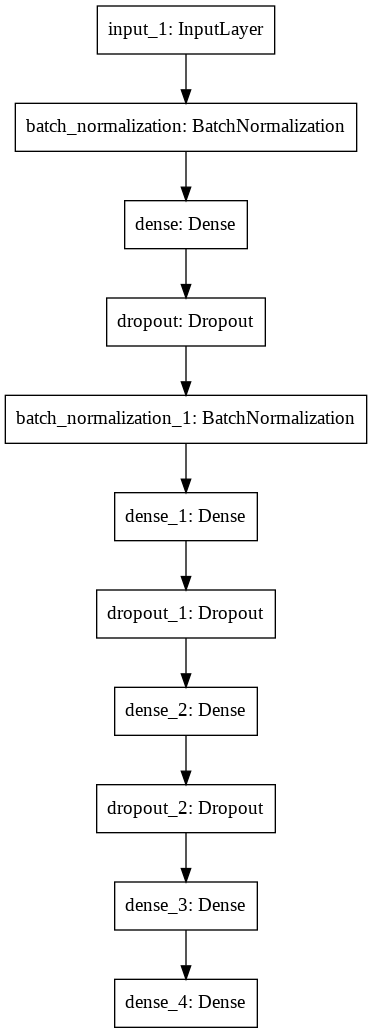

In [11]:
plot_model(model)


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3003)              12012     
_________________________________________________________________
dense (Dense)                (None, 600)               1802400   
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 600)               2400      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               4

In [ ]:
start_time = time.time()
model.compile(loss='binary_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_history = model.fit(X_train,one_hot_train,epochs = 80)
print("training  model takes %s seconds" % round((time.time() - start_time),3))

Epoch 1/80
113/113 [==============================] - 2s 18ms/step - loss: 0.6702 - accuracy: 0.6339
Epoch 2/80
113/113 [==============================] - 2s 18ms/step - loss: 0.5847 - accuracy: 0.7047
Epoch 3/80
113/113 [==============================] - 2s 18ms/step - loss: 0.5263 - accuracy: 0.7416
Epoch 4/80
113/113 [==============================] - 2s 20ms/step - loss: 0.4775 - accuracy: 0.7727
Epoch 5/80
113/113 [==============================] - 2s 18ms/step - loss: 0.4530 - accuracy: 0.7893
Epoch 6/80
113/113 [==============================] - 2s 18ms/step - loss: 0.4289 - accuracy: 0.7916
Epoch 7/80
113/113 [==============================] - 2s 18ms/step - loss: 0.4032 - accuracy: 0.8152
Epoch 8/80
113/113 [==============================] - 2s 18ms/step - loss: 0.3993 - accuracy: 0.8179
Epoch 9/80
113/113 [==============================] - 2s 18ms/step - loss: 0.3715 - accuracy: 0.8246
Epoch 10/80
113/113 [==============================] - 2s 18ms/step - loss: 0.3580 - accura

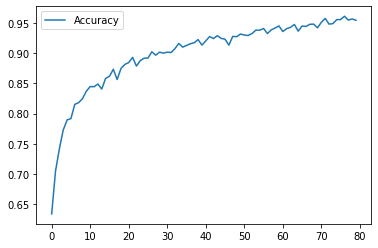

In [ ]:
his_plot = pd.DataFrame(model_history.history)
plt.plot(his_plot['accuracy'],label = 'Accuracy')
plt.legend()

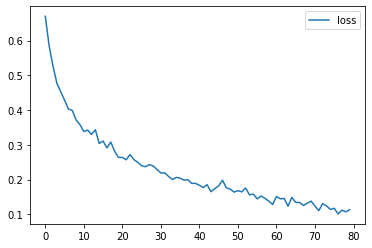

In [ ]:
plt.plot(his_plot['loss'],label = 'loss')
plt.legend()

In [ ]:
# Test on the balanced dataset
start_time = time.time()
y_fitprob = model.predict(X_train)
y_fit = np.argmax(y_fitprob, axis=-1)
print("Testing model on train_dataset takes %s seconds" % round((time.time() - start_time),3))

start_time = time.time()
y_predprob = model.predict(X_test)
y_pred = np.argmax(y_predprob, axis=-1)
print("Testing model on test_dataset takes %s seconds" % round((time.time() - start_time),3))

print("Train dataset -- Accuracy:  %.2f" % sklearn.metrics.accuracy_score(y_train, y_fit))
print("Train dataset -- AUC:  %.2f" % sklearn.metrics.roc_auc_score(one_hot_train, y_fitprob))
print("Test dataset -- Accuracy:  %.2f" % sklearn.metrics.accuracy_score(y_test,y_pred))
print("Test dataset -- AUC:  %.2f" % sklearn.metrics.roc_auc_score(one_hot_test, y_predprob))

Testing model on train_dataset takes 0.542 seconds
Testing model on test_dataset takes 0.205 seconds
Train dataset -- Accuracy:  0.99
Train dataset -- AUC:  1.00
Test dataset -- Accuracy:  0.91
Test dataset -- AUC:  0.98


In [ ]:
# Test on the original dataset

scaler = StandardScaler()
scaler.fit(Ori_X)
ori_scale = scaler.transform(Ori_X)
one_hot_o = tf.one_hot(Ori_Y,depth=2)

start_time = time.time()
y_fitprob_o = model.predict(ori_scale)
y_fit = np.argmax(y_fitprob_o, axis=-1)
print("Testing model on original dataset takes %s seconds" % round((time.time() - start_time),3))

print("Original dataset -- Accuracy:  %.2f" % sklearn.metrics.accuracy_score(Ori_Y, y_fit))
print("Original datase -- AUC:  %.2f" % sklearn.metrics.roc_auc_score(one_hot_o, y_fitprob_o))

Testing model on original dataset takes 0.448 seconds
Original dataset -- Accuracy:  0.90
Original datase -- AUC:  0.98


In [ ]:
# Save the model
model.save("DNN")

# Load the model
predict_model = keras.models.load_model("DNN")

INFO:tensorflow:Assets written to: DNN/assets


## Densely Connected Neural Network works well on both balanced dataset and imbalanced dataset, showing high Accuracy and AUC.